# Batch Parallel Evaluation — pyhvdfa

`compute_hv_batch` evaluates multiple earth models **in parallel** using OS threads.
Each thread gets its own isolated copy of the Fortran module state
(`!$OMP THREADPRIVATE`), so there is **zero IPC, zero pickling, and zero fork overhead**.

This notebook demonstrates:
1. Basic batch usage
2. Speedup over sequential calls
3. An inversion-style loop pattern

In [1]:
import time

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from pyhvdfa import Layer, Model, compute_hv, compute_hv_batch

## 1. Basic batch usage

Build a family of models by varying layer thickness, then evaluate them all
in a single `compute_hv_batch` call.

In [2]:
thicknesses = np.linspace(5, 85, 16)


# 5-layer model: soft top layer (thickness varies) + 3 intermediate layers + halfspace
def make_model(h):
    return Model.from_layers(
        [
            Layer(
                thickness=float(h), vp=500.0, vs=200.0, density=1800.0
            ),  # soft sediment (varies)
            Layer(thickness=15.0, vp=900.0, vs=350.0, density=2000.0),  # transition
            Layer(thickness=25.0, vp=1400.0, vs=600.0, density=2100.0),  # stiffer
            Layer(thickness=40.0, vp=1800.0, vs=900.0, density=2200.0),  # stiff
            Layer(thickness=0.0, vp=2600.0, vs=1300.0, density=2450.0),  # halfspace
        ]
    )


models = [make_model(h) for h in thicknesses]

results = compute_hv_batch(
    models,
    n_workers=4,
    freq_min=0.2,
    freq_max=20.0,
    n_freq=300,
    n_modes_rayleigh=15,
    n_modes_love=15,
    include_body_waves=True,
    nks=256,
)

print(f"Evaluated {len(results)} models")
print(f"Each result: freq({results[0].freq.shape}), hv({results[0].hv.shape})")

Evaluated 16 models
Each result: freq((300,)), hv((300,))


## Plot — thickness sweep (batch)

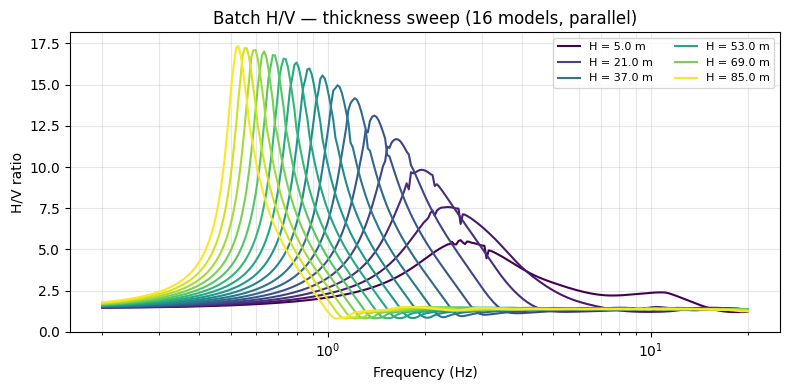

In [3]:
cmap = cm.viridis
fig, ax = plt.subplots(figsize=(8, 4))

for i, (h, r) in enumerate(zip(thicknesses, results)):
    color = cmap(i / (len(thicknesses) - 1))
    ax.semilogx(
        r.freq,
        r.hv,
        color=color,
        linewidth=1.5,
        label=f"H = {h} m" if i % 3 == 0 else None,
    )

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("H/V ratio")
ax.set_title("Batch H/V — thickness sweep (16 models, parallel)")
ax.legend(fontsize=8, ncol=2)
ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Speedup comparison

Compare wall-clock time of sequential `compute_hv` calls vs. `compute_hv_batch`.
Body-wave integrals (`include_body_waves=True`) make each evaluation expensive enough
to measure clearly.


In [9]:
import os

# Compute-intensive settings — body-wave integrals with 500 freq points
kwargs = dict(
    freq_min=0.2,
    freq_max=20.0,
    n_freq=500,
    n_modes_rayleigh=10,
    n_modes_love=10,
    include_body_waves=True,
    nks=256,
)

n_workers = min(min(os.cpu_count() or 4, len(models)), 8)
print(f"Running on {len(models)} models with {n_workers} threads…")

# --- Fully Sequential ---
print(" Fully Sequential... ", end="", flush=True)
t0 = time.perf_counter()
sequential_results = [compute_hv(m, n_workers=1, **kwargs) for m in models]
t_seq = time.perf_counter() - t0
print(f"{t_seq:.2f} s")

# --- Hybrid Sequential ---
print(" Hybrid Sequential... ", end="", flush=True)
t0 = time.perf_counter()
hybrid_results = [compute_hv(m, n_workers=n_workers, **kwargs) for m in models]
t_hyb = time.perf_counter() - t0
print(f"{t_hyb:.2f} s")


# --- Batch ---
print(f"  Batch ({n_workers} workers)... ", end="", flush=True)
t0 = time.perf_counter()
batch_results = compute_hv_batch(models, n_workers=n_workers, **kwargs)
t_batch = time.perf_counter() - t0
print(f"{t_batch:.2f} s")

print(f"\nFully Sequential : {t_seq:.2f} s")
print(f"Hybrid Seq.    : {t_hyb:.2f} s")
print(f"Batch      : {t_batch:.2f} s")

print(
    f"Speedup (Batch vs. Fully Seq.) : {t_seq / t_batch:.1f}×"
    f" | Speedup (Batch vs. Hybrid) : {t_hyb / t_batch:.1f}×"
    f" | Speedup (Hybrid vs. Fully Seq.) : {t_seq / t_hyb:.1f}×"
)

# Verify results are numerically identical
for seq, bat in zip(sequential_results, batch_results):
    np.testing.assert_allclose(bat.hv, seq.hv, rtol=1e-12)
print("\n✓ Batch results match sequential (rtol=1e-12)")

Running on 16 models with 8 threads…
 Fully Sequential... 12.54 s
 Hybrid Sequential... 7.92 s
  Batch (8 workers)... 2.49 s

Fully Sequential : 12.54 s
Hybrid Seq.    : 7.92 s
Batch      : 2.49 s
Speedup (Batch vs. Fully Seq.) : 5.0× | Speedup (Batch vs. Hybrid) : 3.2× | Speedup (Hybrid vs. Fully Seq.) : 1.6×

✓ Batch results match sequential (rtol=1e-12)


## 3. Scaling with number of workers

Measure how batch time changes with `n_workers`.

In [5]:
n_cpu = os.cpu_count() or 4

# 5-layer models: 64 models, body-wave integrals, high mode count → keeps cores busy
long_models = [
    Model.from_layers(
        [
            Layer(thickness=float(h), vp=500.0, vs=200.0, density=1800.0),
            Layer(thickness=15.0, vp=900.0, vs=350.0, density=2000.0),
            Layer(thickness=25.0, vp=1400.0, vs=600.0, density=2100.0),
            Layer(thickness=40.0, vp=1800.0, vs=900.0, density=2200.0),
            Layer(thickness=0.0, vp=2600.0, vs=1300.0, density=2450.0),
        ]
    )
    for h in np.linspace(5, 80, 64)
]

print(f"Launching batch of {len(long_models)} models on {n_cpu} threads…")
print("→ switch to htop now and press H\n")

t0 = time.perf_counter()
_ = compute_hv_batch(
    long_models,
    n_workers=n_cpu,
    freq_min=0.2,
    freq_max=20.0,
    n_freq=400,
    n_modes_rayleigh=5,
    n_modes_love=5,
    include_body_waves=True,
    nks=256,
)
elapsed = time.perf_counter() - t0
print(f"Done in {elapsed:.2f} s")
print(f"Throughput: {len(long_models)/elapsed:.1f} models/s")

Launching batch of 64 models on 16 threads…
→ switch to htop now and press H

Done in 4.92 s
Throughput: 13.0 models/s


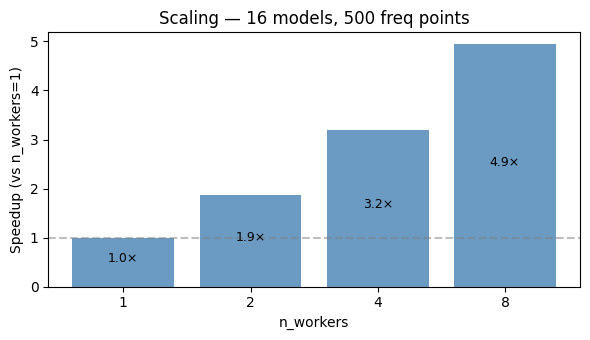

In [7]:
import os

n_cpu = os.cpu_count() or 4
worker_counts = sorted(set([1, 2, 4, min(8, n_cpu)]))

timings = {}
for n in worker_counts:
    t0 = time.perf_counter()
    _ = compute_hv_batch(models, n_workers=n, **kwargs)
    timings[n] = time.perf_counter() - t0

fig, ax = plt.subplots(figsize=(6, 3.5))
workers = list(timings.keys())
times = list(timings.values())
speedups = [times[0] / t for t in times]

ax.bar(
    range(len(workers)),
    speedups,
    tick_label=[str(w) for w in workers],
    color="steelblue",
    alpha=0.8,
)
ax.set_xlabel("n_workers")
ax.set_ylabel("Speedup (vs n_workers=1)")
ax.set_title(f"Scaling — {len(models)} models, {kwargs['n_freq']} freq points")
ax.axhline(1.0, color="gray", linestyle="--", alpha=0.5)
for i, s in enumerate(speedups):
    ax.text(i, s/2, f"{s:.1f}×", ha="center", fontsize=9)
plt.tight_layout()
plt.show()